لطفا تعداد تکرار را وارد کنید:  8


Total time for Accuracy1: 0.6786 seconds
Total time for Overall Accuracy: 0.6976 seconds


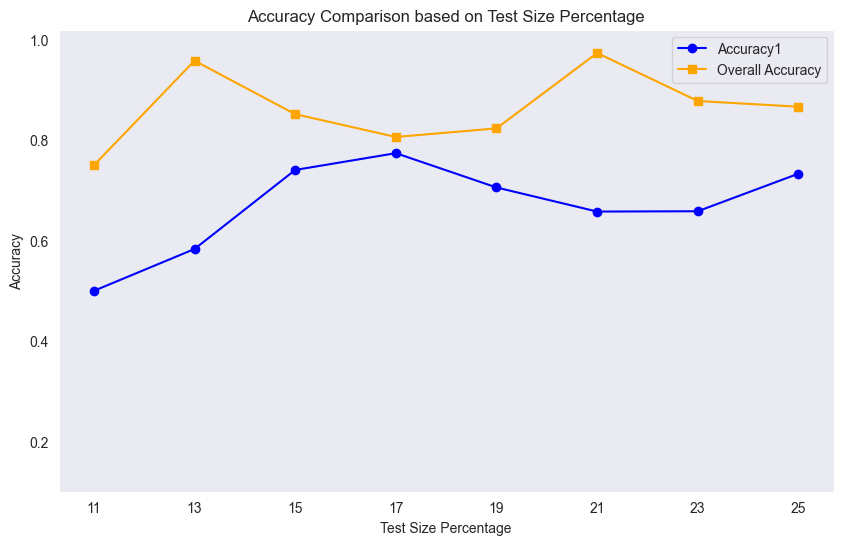

In [4]:
# وارد کردن کتابخانه‌های لازم
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from seaborn import set_style
import time  # اضافه کردن ماژول زمان

set_style('darkgrid')

# تعریف تابع برای محاسبه دقت
def calculate_accuracy(dataset, test_size=0.2, features_to_use=None):
    X = dataset.drop(columns=['target']).values    # ویژگی‌ها
    y = dataset['target'].values   # تارگت‌ها
    
    # تقسیم داده‌ها به مجموعه آموزشی و تست
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
     
    # استانداردسازی ویژگی‌ها
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    predicted_labels_per_features = []
    
    # محاسبه تعداد همسایه‌ها (k)  
    k = int(np.sqrt(len(y_train)))

    knn = KNeighborsClassifier(n_neighbors=k)

    # پردازش ویژگی‌های مشخص شده
    for i in features_to_use:
        X_train_feature = X_train_scaled[:, [i]]
        knn.fit(X_train_feature, y_train)
        predicted_labels = knn.predict(X_test_scaled[:, [i]])
        predicted_labels_per_features.append(predicted_labels)

    if predicted_labels_per_features:    # بررسی اینکه آیا پیش‌بینی انجام شده است
        final_predictions = np.array(predicted_labels_per_features).T  # ترانهاده کردن
        final_target_predictions = mode(final_predictions, axis=1)[0].flatten()
    else:
        raise ValueError("No predictions were made.")

    overall_accuracy = accuracy_score(y_test, final_target_predictions)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred)

    return accuracy1, overall_accuracy

# بارگذاری دیتاست شراب
wine = load_wine()
X = wine.data  # ویژگی‌ها
y = wine.target # تارگت‌ها

# تبدیل به دیتا فریم
df = pd.DataFrame(X, columns=wine.feature_names)
df['target'] = y

# تعریف تابع برای اجرای آزمون
def run_knn(iterations):
    all_accuracy_results = []  # نتیجه دقت همه ویژگی‌ها 
    feature_counts = {feature: 0 for feature in wine.feature_names}  # شمارش دقت ویژگی‌ها

    for _ in range(iterations):
        test_size = np.random.uniform(0.1, 0.3)   # انتخاب تصادفی اندازه تست
        accuracy1, overall_accuracy = calculate_accuracy(df, test_size=test_size, features_to_use=range(len(wine.feature_names)))
        all_accuracy_results.append(overall_accuracy)

        # شمارش ویژگی‌هایی که دقت آن‌ها بالای 70 درصد است
        if overall_accuracy > 0.7:
            for feature in wine.feature_names:
                feature_counts[feature] += 1
                
    return all_accuracy_results, feature_counts  # بازگشت مقادیر پس از اتمام تمام تکرارها

# تعداد تکرار را از کاربر بگیرید 
iterations = int(input("لطفا تعداد تکرار را وارد کنید: "))

# اجرا و دریافت نتایج
all_accuracy_results, feature_counts = run_knn(iterations)

# جمع آوری ویژگی‌هایی که دقتشان بالای 70 درصد بوده است
features_above_75_each_time = [feature for feature, count in feature_counts.items() if count == iterations]
features_indices = [list(wine.feature_names).index(feature) for feature in features_above_75_each_time]

# بررسی دقت‌ها در درصدهای مختلف
test_sizes = np.arange(0.11, 0.25, 0.02)   # از 11% با گام 2
accuracy1_list = []
overall_accuracy_list = []

# زمان‌سنجی کلی برای روش اول (Accuracy1)
start_time_accuracy1 = time.time()
for test_size in test_sizes:
    accuracy1, _ = calculate_accuracy(df, test_size=test_size, features_to_use=range(len(wine.feature_names)))
    accuracy1_list.append(accuracy1)
end_time_accuracy1 = time.time()
total_time_accuracy1 = end_time_accuracy1 - start_time_accuracy1

# زمان‌سنجی کلی برای روش دوم (Overall Accuracy)
start_time_overall_accuracy = time.time()
for test_size in test_sizes:
    _, overall_accuracy = calculate_accuracy(df, test_size=test_size, features_to_use=features_indices)
    overall_accuracy_list.append(overall_accuracy)
end_time_overall_accuracy = time.time()
total_time_overall_accuracy = end_time_overall_accuracy - start_time_overall_accuracy

# نمایش زمان‌های اجرای کلی
print(f"Total time for Accuracy1: {total_time_accuracy1:.4f} seconds")
print(f"Total time for Overall Accuracy: {total_time_overall_accuracy:.4f} seconds")

# رسم هر دو نمودار در یک شکل
plt.figure(figsize=(10, 6))
plt.plot(test_sizes * 100, accuracy1_list, marker='o', label='Accuracy1', color='b')
plt.plot(test_sizes * 100, overall_accuracy_list, marker='s', label='Overall Accuracy', color='orange')
plt.title('Accuracy Comparison based on Test Size Percentage')
plt.xlabel('Test Size Percentage')
plt.ylabel('Accuracy')
plt.xticks(test_sizes * 100)
plt.ylim(0.1, 1.02)
plt.legend()
plt.grid()
plt.show()